# Diploma

Я створив новий датасет для тестування за допомогою ChatGPT. В цьому датасеті трохи більше шуму але в цілому він ідентичний в структурі.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)


Використовується пристрій: cuda


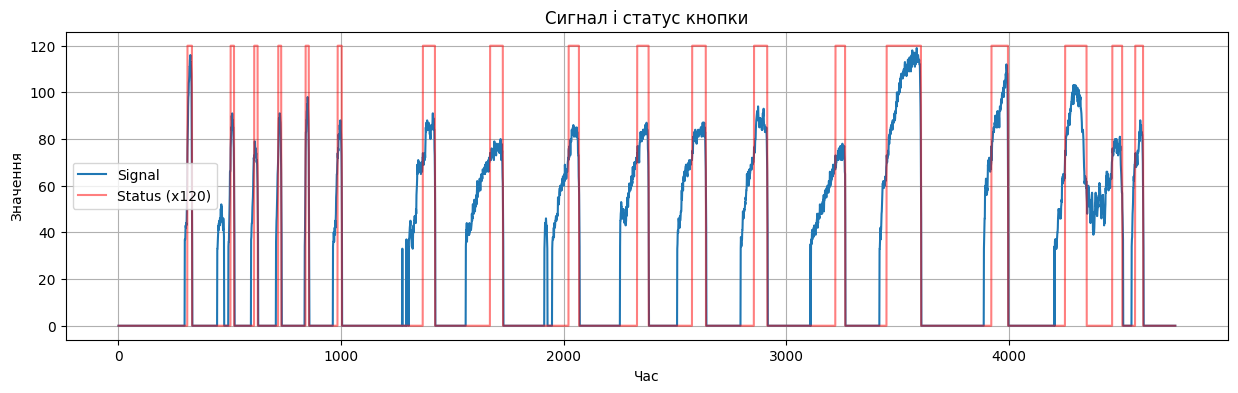

In [3]:
df = pd.read_csv("train_data.csv", sep=';')
plt.figure(figsize=(15, 4))
plt.plot(df['Button0_Sns0_DiffCount'], label='Signal')
plt.plot(df['Button0_Sns0_Status'] * 120, label='Status (x120)', color='red', alpha=0.5)
plt.title("Сигнал і статус кнопки")
plt.xlabel("Час")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class TouchDataset(Dataset):
    def __init__(self, signal, status, window_size=16):
        self.X = []
        self.y = []
        for i in range(len(signal) - window_size):
            self.X.append(signal[i:i+window_size])
            self.y.append(status[i+window_size//2])
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

signal = df['Button0_Sns0_DiffCount'].values
status = df['Button0_Sns0_Status'].values

dataset = TouchDataset(signal, status, window_size=16)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

## Training

### MLP model

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total
        loss_history.append(avg_loss)
        acc_history.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return loss_history, acc_history

In [ ]:
input_size = 16 
mlp_model = MLP(input_size)
loss_history, acc_history = train_model(mlp_model, train_loader, epochs=100, lr=0.001)

Epoch 1/100, Loss: 0.7125, Accuracy: 0.4848
Epoch 2/100, Loss: 0.5064, Accuracy: 0.8638
Epoch 3/100, Loss: 0.3614, Accuracy: 0.8716
Epoch 4/100, Loss: 0.2662, Accuracy: 0.8764
Epoch 5/100, Loss: 0.2319, Accuracy: 0.8809
Epoch 6/100, Loss: 0.2082, Accuracy: 0.8923
Epoch 7/100, Loss: 0.2071, Accuracy: 0.8857
Epoch 8/100, Loss: 0.2005, Accuracy: 0.8910
Epoch 9/100, Loss: 0.2132, Accuracy: 0.8796
Epoch 10/100, Loss: 0.1999, Accuracy: 0.8880
Epoch 11/100, Loss: 0.1909, Accuracy: 0.8959
Epoch 12/100, Loss: 0.1923, Accuracy: 0.8978
Epoch 13/100, Loss: 0.1915, Accuracy: 0.8980
Epoch 14/100, Loss: 0.1845, Accuracy: 0.9014
Epoch 15/100, Loss: 0.1849, Accuracy: 0.9024
Epoch 16/100, Loss: 0.1890, Accuracy: 0.8997
Epoch 17/100, Loss: 0.1763, Accuracy: 0.9085
Epoch 18/100, Loss: 0.1695, Accuracy: 0.9174
Epoch 19/100, Loss: 0.1627, Accuracy: 0.9244
Epoch 20/100, Loss: 0.1665, Accuracy: 0.9138
Epoch 21/100, Loss: 0.1613, Accuracy: 0.9208
Epoch 22/100, Loss: 0.1677, Accuracy: 0.9117
Epoch 23/100, Loss:

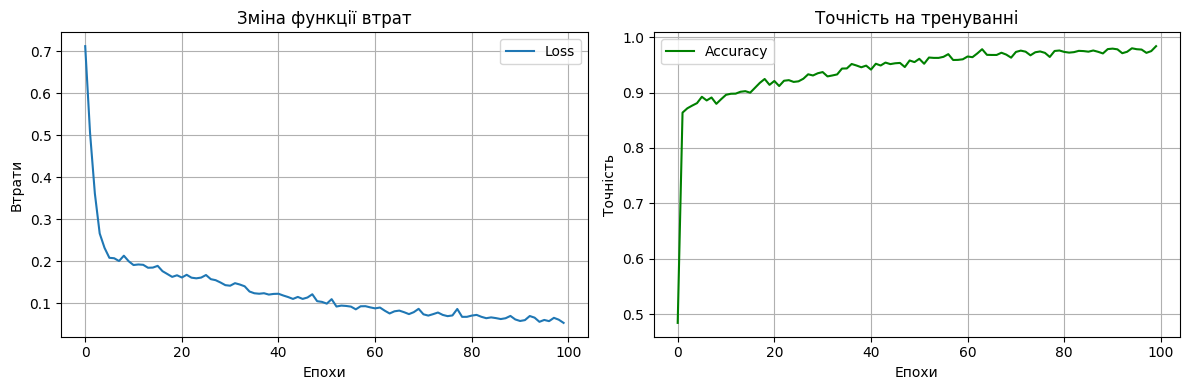

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title("Зміна функції втрат")
plt.xlabel("Епохи")
plt.ylabel("Втрати")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label='Accuracy', color='green')
plt.title("Точність на тренуванні")
plt.xlabel("Епохи")
plt.ylabel("Точність")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### CNN model

In [9]:
class CNN1D(nn.Module):
    def __init__(self, input_length):
        super(CNN1D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)  # вихід завжди (batch_size, 32, 1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                # (batch_size, 32)
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # перетворити (batch, seq_len) → (batch, 1, seq_len)
        x = self.conv(x)
        x = self.classifier(x)
        return x

In [10]:
cnn_model = CNN1D(input_length=16)
loss_history_cnn, acc_history_cnn = train_model(cnn_model, train_loader, epochs=100, lr=0.001)

Epoch 1/100, Loss: 0.5768, Accuracy: 0.7890
Epoch 2/100, Loss: 0.3498, Accuracy: 0.8692
Epoch 3/100, Loss: 0.2523, Accuracy: 0.8705
Epoch 4/100, Loss: 0.2123, Accuracy: 0.8906
Epoch 5/100, Loss: 0.2003, Accuracy: 0.8995
Epoch 6/100, Loss: 0.1927, Accuracy: 0.8990
Epoch 7/100, Loss: 0.1748, Accuracy: 0.9157
Epoch 8/100, Loss: 0.1626, Accuracy: 0.9280
Epoch 9/100, Loss: 0.1579, Accuracy: 0.9292
Epoch 10/100, Loss: 0.1488, Accuracy: 0.9356
Epoch 11/100, Loss: 0.1500, Accuracy: 0.9305
Epoch 12/100, Loss: 0.1382, Accuracy: 0.9434
Epoch 13/100, Loss: 0.1368, Accuracy: 0.9387
Epoch 14/100, Loss: 0.1278, Accuracy: 0.9474
Epoch 15/100, Loss: 0.1252, Accuracy: 0.9468
Epoch 16/100, Loss: 0.1416, Accuracy: 0.9349
Epoch 17/100, Loss: 0.1198, Accuracy: 0.9499
Epoch 18/100, Loss: 0.1134, Accuracy: 0.9527
Epoch 19/100, Loss: 0.1182, Accuracy: 0.9459
Epoch 20/100, Loss: 0.1122, Accuracy: 0.9531
Epoch 21/100, Loss: 0.1168, Accuracy: 0.9461
Epoch 22/100, Loss: 0.1007, Accuracy: 0.9578
Epoch 23/100, Loss:

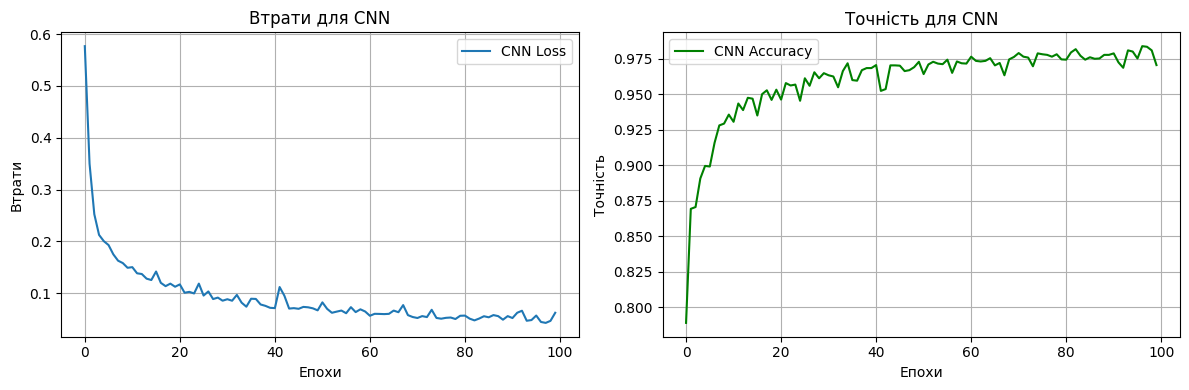

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history_cnn, label='CNN Loss')
plt.title("Втрати для CNN")
plt.xlabel("Епохи")
plt.ylabel("Втрати")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history_cnn, label='CNN Accuracy', color='green')
plt.title("Точність для CNN")
plt.xlabel("Епохи")
plt.ylabel("Точність")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### LSTM model

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # перетворити (batch, seq_len) → (batch, seq_len, 1)
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]  # останній часовий крок
        return self.classifier(last_hidden)

In [13]:
lstm_model = LSTMClassifier(input_size=1, hidden_size=32, num_layers=1)
loss_history_lstm, acc_history_lstm = train_model(lstm_model, train_loader, epochs=100, lr=0.001)

Epoch 1/100, Loss: 0.4779, Accuracy: 0.7237
Epoch 2/100, Loss: 0.1959, Accuracy: 0.8891
Epoch 3/100, Loss: 0.1205, Accuracy: 0.9677
Epoch 4/100, Loss: 0.0860, Accuracy: 0.9761
Epoch 5/100, Loss: 0.0770, Accuracy: 0.9772
Epoch 6/100, Loss: 0.0635, Accuracy: 0.9789
Epoch 7/100, Loss: 0.0593, Accuracy: 0.9797
Epoch 8/100, Loss: 0.0660, Accuracy: 0.9761
Epoch 9/100, Loss: 0.0513, Accuracy: 0.9825
Epoch 10/100, Loss: 0.0475, Accuracy: 0.9825
Epoch 11/100, Loss: 0.0451, Accuracy: 0.9846
Epoch 12/100, Loss: 0.0444, Accuracy: 0.9829
Epoch 13/100, Loss: 0.0421, Accuracy: 0.9844
Epoch 14/100, Loss: 0.0403, Accuracy: 0.9861
Epoch 15/100, Loss: 0.0399, Accuracy: 0.9852
Epoch 16/100, Loss: 0.0476, Accuracy: 0.9812
Epoch 17/100, Loss: 0.0392, Accuracy: 0.9856
Epoch 18/100, Loss: 0.0402, Accuracy: 0.9856
Epoch 19/100, Loss: 0.0407, Accuracy: 0.9846
Epoch 20/100, Loss: 0.0380, Accuracy: 0.9850
Epoch 21/100, Loss: 0.0364, Accuracy: 0.9869
Epoch 22/100, Loss: 0.0352, Accuracy: 0.9856
Epoch 23/100, Loss:

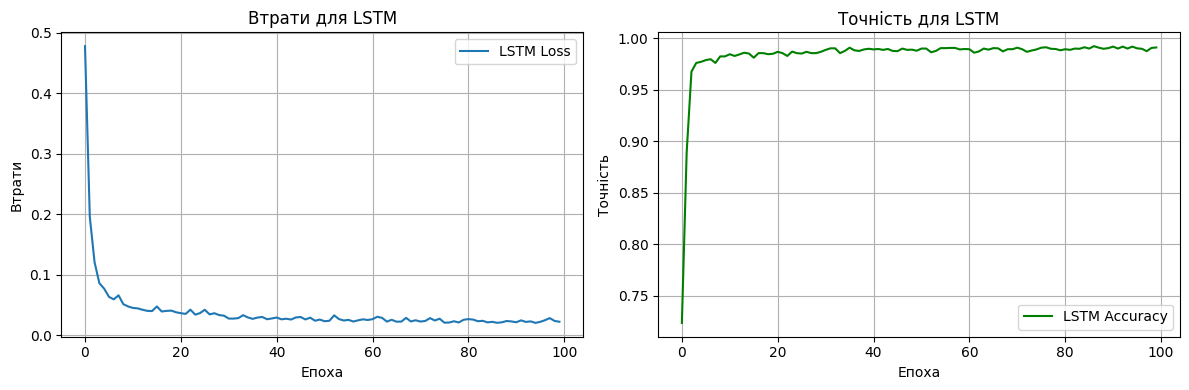

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history_lstm, label='LSTM Loss')
plt.title("Втрати для LSTM")
plt.xlabel("Епоха")
plt.ylabel("Втрати")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history_lstm, label='LSTM Accuracy', color='green')
plt.title("Точність для LSTM")
plt.xlabel("Епоха")
plt.ylabel("Точність")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Готуємо вхідні вікна та цілі вручну
def prepare_windows(signal, status, window_size=16):
    X = []
    y = []
    for i in range(len(signal) - window_size):
        X.append(signal[i:i+window_size])
        y.append(status[i + window_size // 2])
    return np.array(X), np.array(y)

X, y = prepare_windows(signal, status, window_size=16)

# Розділення на тренувальний і валідаційний набори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Навчання логістичної регресії
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Оцінка на валідації
y_pred = logreg.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Точність логістичної регресії: {acc:.4f}")
print(classification_report(y_val, y_pred, digits=4))

Точність логістичної регресії: 0.9905
              precision    recall  f1-score   support

           0     0.9924    0.9962    0.9943       784
           1     0.9812    0.9632    0.9721       163

    accuracy                         0.9905       947
   macro avg     0.9868    0.9797    0.9832       947
weighted avg     0.9905    0.9905    0.9905       947



### Training results

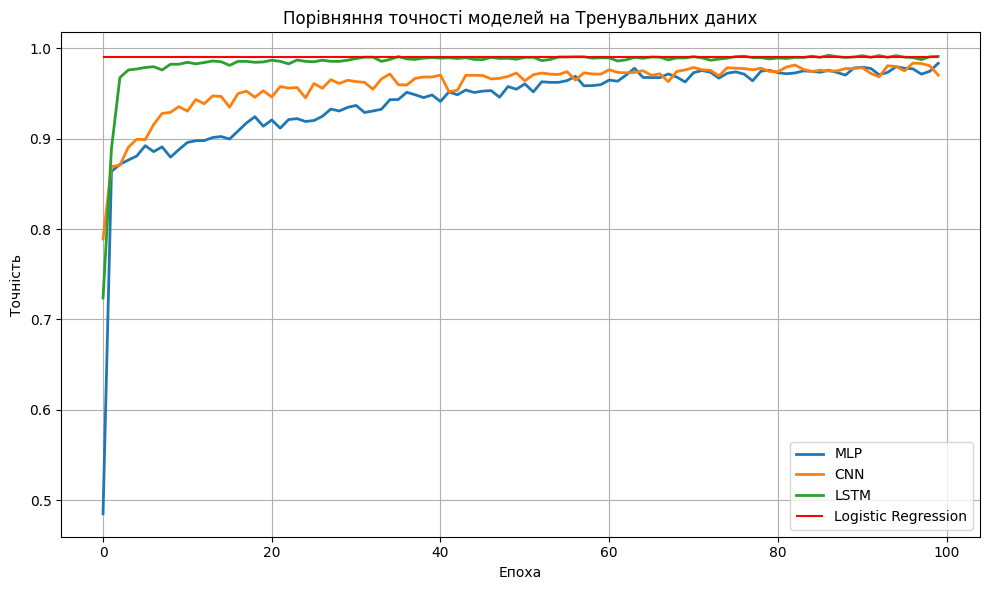

In [16]:
plt.figure(figsize=(10, 6))

# Точності по епохах для нейромереж
plt.plot(acc_history, label='MLP', linewidth=2)
plt.plot(acc_history_cnn, label='CNN', linewidth=2)
plt.plot(acc_history_lstm, label='LSTM', linewidth=2)

# Горизонтальна лінія для логістичної регресії
plt.hlines(acc, xmin=0, xmax=len(acc_history)-1, colors='red', linestyles='-', label='Logistic Regression')

plt.title("Порівняння точності моделей на Тренувальних даних")
plt.xlabel("Епоха")
plt.ylabel("Точність")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Testing

In [17]:
df_test = pd.read_csv("test_data_gpt.csv", sep=';')
signal_test = df_test['Button0_Sns0_DiffCount'].values
status_test = df_test['Button0_Sns0_Status'].values
X_test, y_test = prepare_windows(signal_test, status_test, window_size=16)

In [18]:
def evaluate_pytorch_model(model, X, y):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device).unsqueeze(1)
        outputs = model(X_tensor)
        predicted = (outputs > 0.5).float()
        acc = (predicted == y_tensor).float().mean().item()
    return acc

acc_mlp_test = evaluate_pytorch_model(mlp_model, X_test, y_test)
acc_cnn_test = evaluate_pytorch_model(cnn_model, X_test, y_test)
acc_lstm_test = evaluate_pytorch_model(lstm_model, X_test, y_test)

print(f"MLP Test Accuracy: {acc_mlp_test:.4f}")
print(f"CNN Test Accuracy: {acc_cnn_test:.4f}")
print(f"LSTM Test Accuracy: {acc_lstm_test:.4f}")

MLP Test Accuracy: 0.9651
CNN Test Accuracy: 0.9561
LSTM Test Accuracy: 0.9713


In [19]:
y_pred_logreg = logreg.predict(X_test)
acc_logreg_test = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Test Accuracy: {acc_logreg_test:.4f}")

Logistic Regression Test Accuracy: 0.9569


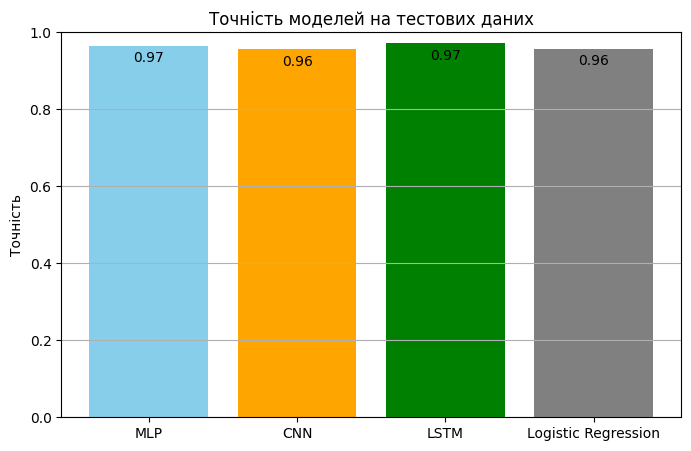

In [20]:
models = ['MLP', 'CNN', 'LSTM', 'Logistic Regression']
accuracies = [acc_mlp_test, acc_cnn_test, acc_lstm_test, acc_logreg_test]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'green', 'gray'])
plt.ylim(0, 1)
plt.ylabel("Точність")
plt.title("Точність моделей на тестових даних")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.05, f"{height:.2f}", ha='center', va='bottom', color='black')
plt.grid(True, axis='y')
plt.show()

## Models Predictions visualizations

In [21]:
def plot_model_prediction_slice(signal, true_status, predicted_status, title, scale=120, start=500, end=1500):
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(start, end), signal[start:end], label='Signal')
    plt.plot(np.arange(start, end), true_status[start:end] * scale, label='Ground Truth (x{})'.format(scale), color='red', alpha=0.5)
    plt.plot(np.arange(start, end), predicted_status[start:end] * scale, label='Prediction (x{})'.format(scale), color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("Час (індекс)")
    plt.ylabel("Значення")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
# Створимо вікна ще раз (щоб мати прив'язку до індексів сигналу)
X_test, y_test = prepare_windows(signal_test, status_test, window_size=16)

# Для вирівнювання з оригінальним сигналом:
# результати йдуть з центру кожного вікна, тобто offset
offset = 16 // 2
adjusted_indices = np.arange(offset, offset + len(y_test))

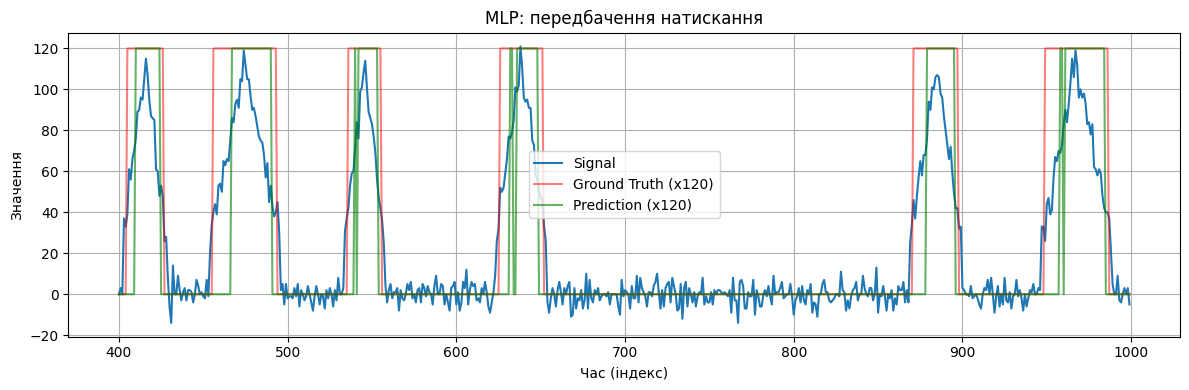

In [23]:
mlp_model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    mlp_preds = (mlp_model(X_tensor) > 0.5).float().cpu().numpy().flatten()

status_plot = np.zeros_like(signal_test)
status_plot[adjusted_indices] = mlp_preds
plot_model_prediction_slice(signal_test, status_test, status_plot, "MLP: передбачення натискання", start=400, end=1000)

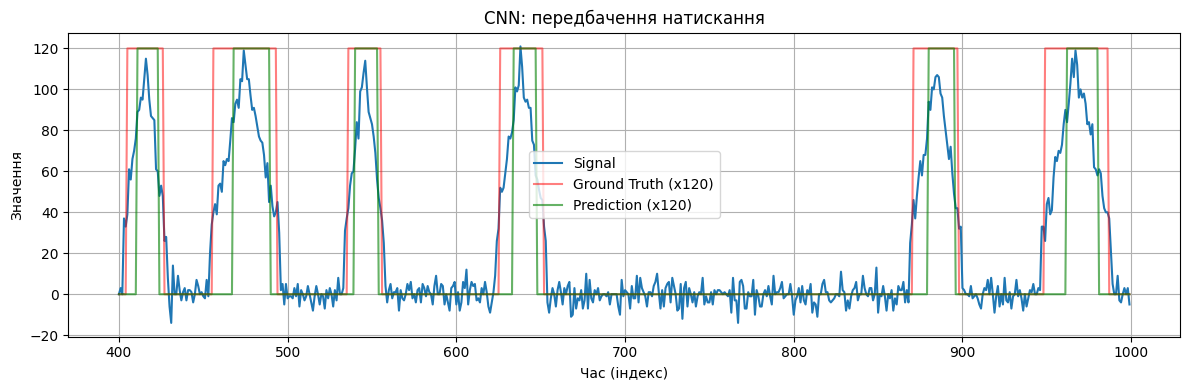

In [30]:
cnn_model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    cnn_preds = (cnn_model(X_tensor) > 0.5).float().cpu().numpy().flatten()

status_plot = np.zeros_like(signal_test)
status_plot[adjusted_indices] = cnn_preds
plot_model_prediction_slice(signal_test, status_test, status_plot, "CNN: передбачення натискання", start=400, end=1000)

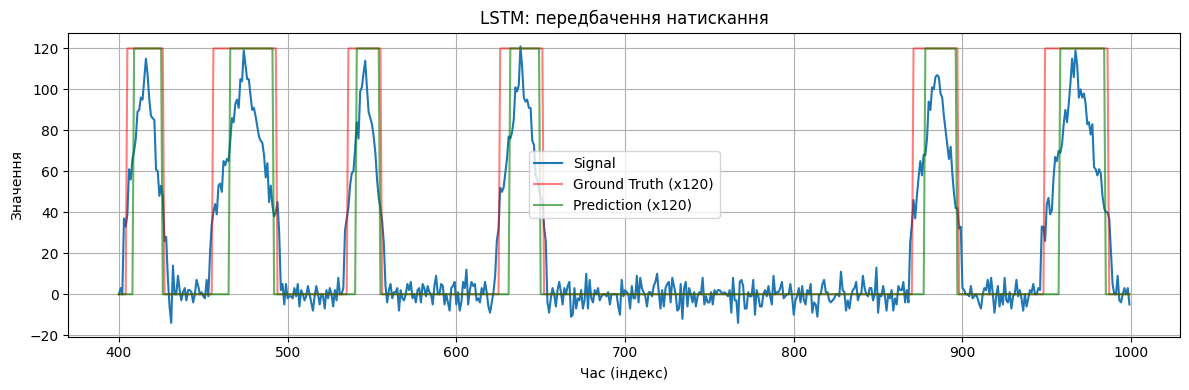

In [33]:
lstm_model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    lstm_preds = (lstm_model(X_tensor) > 0.5).float().cpu().numpy().flatten()

status_plot = np.zeros_like(signal_test)
status_plot[adjusted_indices] = lstm_preds
plot_model_prediction_slice(signal_test, status_test, status_plot, "LSTM: передбачення натискання", start=400, end=1000)

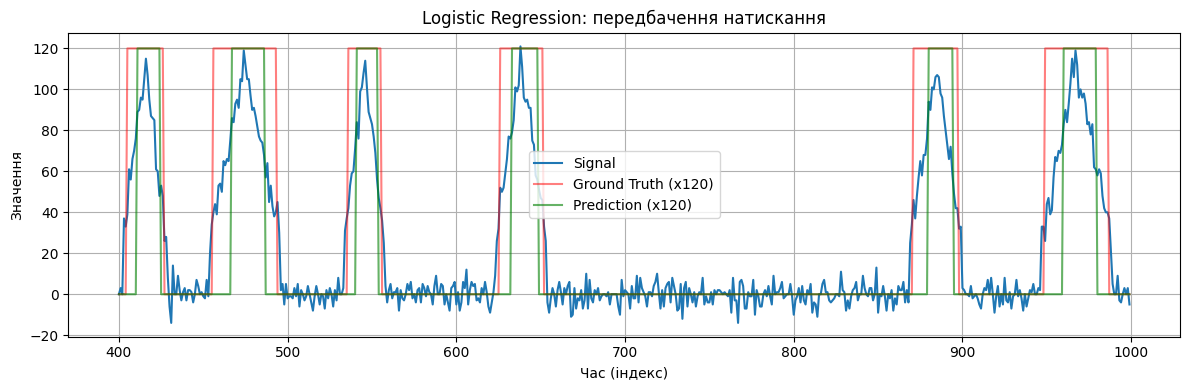

In [36]:
logreg_preds = logreg.predict(X_test)

status_plot = np.zeros_like(signal_test)
status_plot[adjusted_indices] = logreg_preds
plot_model_prediction_slice(signal_test, status_test, status_plot, "Logistic Regression: передбачення натискання", start=400, end=1000)

# Reasoning

MLP:
- Сильні сторони: Швидко тренується, добре справляється з задачами, де немає складної часової структури. Мав стабільне зростання точності під час тренування.
- Слабкі сторони: Помітні надмірні спрацювання — на графіках модель часто "промахується" вглиб часу, тобто коли ground truth показує одне натискання, MLP дає кілька зелених відповідей (помилкові дублікати). Це означає, що модель не "розуміє", коли натискання закінчилось, бо вона не враховує контекст.

CNN:
- Сильні сторони: Вміє знаходити локальні шаблони — різкі підйоми/спади в сигналі. Показала дуже хорошу точність при навчанні (до 0.9852).
- Слабкі сторони: Аналогічно до MLP, часто "розтягує" сигнал, тобто детектує одне натискання як кілька поспіль. Це пов’язано з тим, що CNN працює на фіксованих шаблонах, а не на змінній часовій поведінці — вона не враховує історію сигналу у повному сенсі.

LSTM:
- Сильні сторони: Найкраща узагальнена поведінка. LSTM враховує послідовність значень у часі, тому розуміє динаміку сигналу: як саме він піднімається, як довго утримується і як спадає.
- Результати: Найвища точність на тесті (0.9713). На графіках дуже акуратно розмічає натискання, без дублювання, без помилкових класифікацій.
- Слабкі сторони: Тренується повільніше. Іноді може втрачати надто короткі сигнали, якщо вони не мають чіткої динаміки.

Logistic Regression:
- Сильні сторони: Дуже проста модель, дуже швидко тренується. Показала точність ~0.9905 на валідації та ~0.9569 на тесті — вражаючий результат для такої простої архітектури.
- Поведінка: Як не дивно, логістична регресія також поводиться акуратніше, ніж MLP або CNN, і не дає надлишкових спрацювань. Чому так? Бо вона має жорстку межу рішень, і не схильна до надмірного реагування на шум.

---

Чому MLP і CNN "розтягують" сигнал?

На графіках ми бачимо, що:

* У місці, де ground truth показує одне натискання (один "пік"), MLP або CNN дають 2–3 послідовні одиниці.

* Це відбувається через те, що ці моделі бачать лише вікно сигналу, але не розуміють, чи натискання вже почалося або завершилось — тобто не мають пам’яті.

* Вони бачать високий сигнал, і кожного разу заново вирішують: «о, мабуть натискання» — навіть якщо попередній крок вже його зафіксував.

---

Загальний висновок:

* LSTM — найкращий вибір для задачі класифікації натискань у зашумленому сигналі. Враховує час, динаміку, плавність.

* Logistic Regression — відмінний базовий варіант. Якщо потрібна проста модель без GPU.

* MLP і CNN — непогані, але потребують постобробки (наприклад, debounce-фільтр, що прибирає дублікати).